In [111]:
from finance_utils.electrical.china.spot.discrete.probabilistic_forecast import DiscreteSpot,ProbabilisticDiscreteCurve
from finance_utils.electrical.china.spot.discrete.testback import TestBack,AnarchismRecycle, SampleRecycle
import numpy

In [112]:
from data_utils.stochastic_utils.distributions.baseclass import ABCDistribution
from data_utils.stochastic_utils.distributions.basic_distributions import NormalDistribution

In [113]:
dayahead = ProbabilisticDiscreteCurve([
    NormalDistribution(200, 9),
    NormalDistribution(201, 8),
    NormalDistribution(203, 7),
    NormalDistribution(102, 6),
])

realtime = ProbabilisticDiscreteCurve([
    NormalDistribution(200 * 1.2, 20),
    NormalDistribution(201 * 1.1, 21),
    NormalDistribution(203 * 1.2, 22),
    NormalDistribution(102 * 1.1, 53),
])

quantity = ProbabilisticDiscreteCurve([
    NormalDistribution(10, 5),
    NormalDistribution(9, 3),
    NormalDistribution(15, 1),
    NormalDistribution(25, 2),
])

spot = DiscreteSpot(dayahead, realtime, quantity)

In [114]:
from matplotlib import pyplot

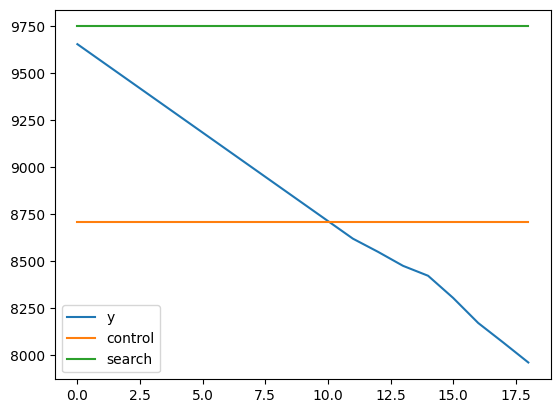

In [150]:
testback = TestBack(spot.random_sample(n=100, eps=100, use_random=True))
# y = [
#     numpy.median(
#         testback.testback_yield([i] * 4, f=SampleRecycle, trigger_rate=0.05, punishment_rate=0.5).yield_curve
#     ) for i in range(1,20)
# ]
y_hat = [
    numpy.mean(
        testback.testback_yield([i] * 4, f=SampleRecycle, trigger_rate=0.01, punishment_rate=0.1).yield_curve
    ) for i in range(1,20)
]
y_control = [
    numpy.mean(
        testback.testback_yield(spot.quantity.value_list, f=SampleRecycle, trigger_rate=0.01, punishment_rate=0.1).yield_curve
    ) for i in range(1,20)
]
y_search = [
    numpy.mean(
        testback.testback_yield([0, 0, 0, 0], 
                                f=SampleRecycle, trigger_rate=0.01, punishment_rate=0.1).yield_curve
    ) for i in range(1,20)
]
# pyplot.plot(y)
pyplot.plot(y_hat)
pyplot.plot(y_control)
pyplot.plot(y_search)
pyplot.legend(["y","control","search"])
pyplot.show()

In [127]:
print(testback.random_grid_search([13, 13, 13, 13], submit_min=-5, submit_max=5, eps=400))

([13.22869003481981, 17.428614910762093, 13.196310626764209, 17.743504877631956], np.float64(6487.761431098571))


In [149]:
crgs = testback.continuous_random_grid_search(spot.quantity.value_list, submit_min=-5, submit_max=5, eps=50, rounds=50, f=SampleRecycle, trigger_rate=0.01, punishment_rate=0.1)
print([i[1] for i in crgs])
print(crgs[-1][0])

[np.float64(8895.502947987105), np.float64(9172.120993171171), np.float64(9384.04110447552), np.float64(9533.693560554206), np.float64(9624.075026346276), np.float64(9664.39782267974), np.float64(9684.124513837707), np.float64(9725.112946077197), np.float64(9759.604410383052), np.float64(9804.305187564898), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.3602982715), np.float64(9813.36029827